# Assignment 1(a) Logistic Regression

*(Deep Learning (80240743), Spring 2023)*  
Due at **23:55, March 15, 2023**  



---

The CIFAR-10 dataset is widely used for image classification in machine learning,  
consisting of 60000 32x32 color images in 10 classes, with 6000 images per class.  
There are 50000 training images and 10000 test images. More details on the dataset  
itself can be found at https://www.cs.toronto.edu/~kriz/cifar.html. Further  
description in much greater detail and the methodology followed during data  
collection could be found at [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf).

In this assignment, you will implement image classification algorithms using  
(a) logistic regression and (b) softmax regression. For logistic regression, we  
will only use a subset of the CIFAR-10 dataset containing only 2 categories.

We have provided some starting code. Make sure the dataset file  
`cifar-10-python.zip` stays within the same directory. No need to unzip this  
dataset file as the program can read directly into zip archives.You will need  
**Python 3** and **Jupyter Notebook** or any program capable of editing and running  
this `.ipynb` file, as well as Python packages `tqdm`, `numpy` and `matplotlib`.

---

This file is split into 3 sections:

1. **Load Dataset**: The starting code for loading data from the dataset file. There's  
nothing to be done on your part in this section. You may read through this section  
if you're interested, or you can head straight towards the next section.

2. **Training**: This section holds most of your work. Note that any neural network  
framework such as TensorFlow, PyTorch, etc. are **prohibited** in finishing this  
assignment except for data preprocessing.

    - Implement logistic regression to perform binary classification by filling in code  
    in this section. Use regularization. Record loss and accuracy during training.

    - Experiment with hyperparameters (batch size, learning rate, regularization, etc.),  
    and observe the way they affect classification performance. 

3. **Report**: Record your experiment results and write down your observation into a  
tiny report.

## 1. Load Dataset


In [1]:
import os
import pathlib
import tqdm
import numpy as np
import pickle
import zipfile
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
%matplotlib inline


In [2]:
# Read from dataset file

with zipfile.ZipFile('cifar-10-python.zip', 'r') as z:
    def pickle_load_from_zip_entry(name):
        with z.open(name) as f:
            return pickle.load(f, encoding='latin1')

    label_names = pickle_load_from_zip_entry('cifar-10-batches-py/batches.meta')['label_names']
    print('label_names:', label_names)

    print('\nLoading train set ...')
    train_data_dicts = [
        pickle_load_from_zip_entry(f'cifar-10-batches-py/{filename}')
        for filename in ('data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5',)]
    train_data = np.concatenate([d['data'].astype(np.float32) for d in train_data_dicts]) / 255.
    train_labels = np.concatenate([d['labels'] for d in train_data_dicts])
    print(f'train_data: <np.array of shape: {train_data.shape} dtype: {train_data.dtype}>')
    print(f'train_labels: <np.array of shape: {train_labels.shape} dtype: {train_labels.dtype}>')

    print('\nLoading test set ...')
    test_data_dict = pickle_load_from_zip_entry('cifar-10-batches-py/test_batch')
    test_data = test_data_dict['data'].astype(np.float32) / 255.
    test_labels = np.array(test_data_dict['labels'])
    print(f'test_data: <np.array of shape: {test_data.shape} dtype: {test_data.dtype}>')
    print(f'test_labels: <np.array of shape: {test_labels.shape} dtype: {test_labels.dtype}>')


label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Loading train set ...
train_data: <np.array of shape: (50000, 3072) dtype: float32>
train_labels: <np.array of shape: (50000,) dtype: int32>

Loading test set ...
test_data: <np.array of shape: (10000, 3072) dtype: float32>
test_labels: <np.array of shape: (10000,) dtype: int32>


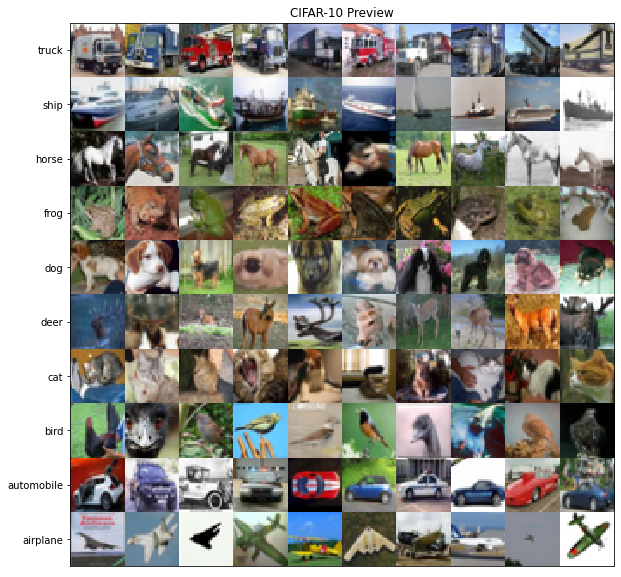

In [3]:
# Preview dataset

_ = plt.figure(figsize=(10, 10))
_ = plt.title('CIFAR-10 Preview')
for label_index, label_name in enumerate(label_names):
    for img_index, img_data in enumerate(test_data[test_labels == label_index][:10]):
        _ = plt.imshow(
            np.moveaxis(np.reshape(img_data, (3, 32, 32)), 0, 2),
            interpolation='nearest', extent=[img_index, img_index + 1, label_index, label_index + 1])
_ = plt.xticks([])
_ = plt.yticks(np.arange(len(label_names)) + 0.5, label_names)
_ = plt.xlim(0, 10)
_ = plt.ylim(0, len(label_names))

In [4]:
# Keep only 2 categories and remove all others from both image data and labels

active_label_indices = [0, 1]

print('\nTaking subset of label names ...')
label_names = [label_names[label_index] for label_index in active_label_indices]
print('label_names:', label_names)

print('\nTaking subset of train set ...')
train_data = train_data[np.any(train_labels[:, None] == active_label_indices, axis=-1)]
train_labels = train_labels[np.any(train_labels[:, None] == active_label_indices, axis=-1)]
print(f'train_data: <np.array of shape: {train_data.shape} dtype: {train_data.dtype}>')
print(f'train_labels: <np.array of shape: {train_labels.shape} dtype: {train_labels.dtype}>')

print('\nTaking subset of test set ...')
test_data = test_data[np.any(test_labels[:, None] == active_label_indices, axis=-1)]
test_labels = test_labels[np.any(test_labels[:, None] == active_label_indices, axis=-1)]
print(f'test_data: <np.array of shape: {test_data.shape} dtype: {test_data.dtype}>')
print(f'test_labels: <np.array of shape: {test_labels.shape} dtype: {test_labels.dtype}>')



Taking subset of label names ...
label_names: ['airplane', 'automobile']

Taking subset of train set ...
train_data: <np.array of shape: (10000, 3072) dtype: float32>
train_labels: <np.array of shape: (10000,) dtype: int32>

Taking subset of test set ...
test_data: <np.array of shape: (2000, 3072) dtype: float32>
test_labels: <np.array of shape: (2000,) dtype: int32>


## 2. Training

loss 0.673 acc 0.625: 100%|██████████| 157/157 [00:01<00:00, 152.64it/s]


  - test acc: 0.749


loss 0.654 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 164.76it/s]


  - test acc: 0.770


loss 0.643 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 162.44it/s]


  - test acc: 0.774


loss 0.636 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 163.72it/s]


  - test acc: 0.778


loss 0.631 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 171.18it/s]


  - test acc: 0.779


loss 0.628 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 168.40it/s]


  - test acc: 0.783


loss 0.626 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 178.06it/s]


  - test acc: 0.785


loss 0.624 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 163.59it/s]


  - test acc: 0.786


loss 0.622 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 171.94it/s]


  - test acc: 0.787


loss 0.621 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 163.29it/s]


  - test acc: 0.788


loss 0.619 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 166.66it/s]


  - test acc: 0.791


loss 0.618 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 154.79it/s]


  - test acc: 0.793


loss 0.617 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 147.79it/s]


  - test acc: 0.797


loss 0.616 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 149.57it/s]


  - test acc: 0.798


loss 0.615 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 155.87it/s]


  - test acc: 0.797


loss 0.614 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 142.23it/s]


  - test acc: 0.796


loss 0.613 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 150.34it/s]


  - test acc: 0.795


loss 0.612 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 135.04it/s]


  - test acc: 0.796


loss 0.611 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 162.43it/s]


  - test acc: 0.796


loss 0.610 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 163.90it/s]


  - test acc: 0.797


loss 0.609 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 153.57it/s]


  - test acc: 0.799


loss 0.608 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 172.45it/s]


  - test acc: 0.799


loss 0.607 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 166.84it/s]


  - test acc: 0.800


loss 0.606 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 161.99it/s]


  - test acc: 0.800


loss 0.605 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 157.08it/s]


  - test acc: 0.800


loss 0.605 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 176.51it/s]


  - test acc: 0.801


loss 0.604 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 157.48it/s]


  - test acc: 0.803


loss 0.603 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 158.80it/s]


  - test acc: 0.803


loss 0.602 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 152.55it/s]


  - test acc: 0.803


loss 0.601 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 154.08it/s]


  - test acc: 0.803


loss 0.601 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 150.97it/s]


  - test acc: 0.804


loss 0.600 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 162.38it/s]


  - test acc: 0.805


loss 0.599 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 161.26it/s]


  - test acc: 0.805


loss 0.599 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 168.52it/s]


  - test acc: 0.806


loss 0.598 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 160.21it/s]


  - test acc: 0.807


loss 0.597 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 176.21it/s]


  - test acc: 0.807


loss 0.597 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 167.88it/s]


  - test acc: 0.809


loss 0.596 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 171.80it/s]


  - test acc: 0.809


loss 0.595 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 169.14it/s]


  - test acc: 0.811


loss 0.595 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 175.56it/s]


  - test acc: 0.812


loss 0.594 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 162.81it/s]


  - test acc: 0.812


loss 0.593 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 176.13it/s]


  - test acc: 0.812


loss 0.593 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 158.93it/s]


  - test acc: 0.812


loss 0.592 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 167.61it/s]


  - test acc: 0.814


loss 0.592 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 162.88it/s]


  - test acc: 0.812


loss 0.591 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 166.64it/s]


  - test acc: 0.813


loss 0.591 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 127.62it/s]


  - test acc: 0.814


loss 0.590 acc 0.625: 100%|██████████| 157/157 [00:01<00:00, 154.88it/s]


  - test acc: 0.814


loss 0.590 acc 0.625: 100%|██████████| 157/157 [00:01<00:00, 156.99it/s]


  - test acc: 0.813


loss 0.589 acc 0.625: 100%|██████████| 157/157 [00:00<00:00, 164.21it/s]


  - test acc: 0.814


loss 0.589 acc 0.625: 100%|██████████| 157/157 [00:00<00:00, 174.12it/s]


  - test acc: 0.815


loss 0.588 acc 0.625: 100%|██████████| 157/157 [00:00<00:00, 174.38it/s]


  - test acc: 0.815


loss 0.588 acc 0.625: 100%|██████████| 157/157 [00:00<00:00, 157.75it/s]


  - test acc: 0.815


loss 0.587 acc 0.625: 100%|██████████| 157/157 [00:00<00:00, 166.10it/s]


  - test acc: 0.815


loss 0.587 acc 0.625: 100%|██████████| 157/157 [00:00<00:00, 172.12it/s]


  - test acc: 0.816


loss 0.586 acc 0.625: 100%|██████████| 157/157 [00:00<00:00, 174.26it/s]


  - test acc: 0.815


loss 0.586 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 168.44it/s]


  - test acc: 0.816


loss 0.585 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 170.67it/s]


  - test acc: 0.815


loss 0.585 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 160.09it/s]


  - test acc: 0.816


loss 0.585 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 144.19it/s]


  - test acc: 0.817


loss 0.584 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 158.60it/s]


  - test acc: 0.817


loss 0.584 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 157.80it/s]


  - test acc: 0.817


loss 0.583 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 147.96it/s]


  - test acc: 0.818


loss 0.583 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 154.31it/s]


  - test acc: 0.817


loss 0.583 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 152.74it/s]


  - test acc: 0.817


loss 0.582 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 164.74it/s]


  - test acc: 0.817


loss 0.582 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 174.06it/s]


  - test acc: 0.817


loss 0.581 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 164.34it/s]


  - test acc: 0.817


loss 0.581 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 173.06it/s]


  - test acc: 0.818


loss 0.581 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 174.96it/s]


  - test acc: 0.818


loss 0.580 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 158.60it/s]


  - test acc: 0.818


loss 0.580 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 174.75it/s]


  - test acc: 0.818


loss 0.580 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 159.34it/s]


  - test acc: 0.818


loss 0.579 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 177.27it/s]


  - test acc: 0.818


loss 0.579 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 157.24it/s]


  - test acc: 0.818


loss 0.579 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 154.74it/s]


  - test acc: 0.818


loss 0.578 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 161.15it/s]


  - test acc: 0.819


loss 0.578 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 159.80it/s]


  - test acc: 0.819


loss 0.578 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 142.47it/s]


  - test acc: 0.819


loss 0.577 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 143.79it/s]


  - test acc: 0.820


loss 0.577 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 152.86it/s]


  - test acc: 0.820


loss 0.577 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 161.93it/s]


  - test acc: 0.820


loss 0.576 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 155.10it/s]


  - test acc: 0.820


loss 0.576 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 163.08it/s]


  - test acc: 0.820


loss 0.576 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 162.69it/s]


  - test acc: 0.819


loss 0.576 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 145.55it/s]


  - test acc: 0.819


loss 0.575 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 165.66it/s]


  - test acc: 0.819


loss 0.575 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 157.59it/s]


  - test acc: 0.819


loss 0.575 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 169.88it/s]


  - test acc: 0.819


loss 0.574 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 156.74it/s]


  - test acc: 0.819


loss 0.574 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 151.77it/s]


  - test acc: 0.819


loss 0.574 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 141.28it/s]


  - test acc: 0.819


loss 0.574 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 143.66it/s]


  - test acc: 0.819


loss 0.573 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 147.14it/s]


  - test acc: 0.820


loss 0.573 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 153.30it/s]


  - test acc: 0.820


loss 0.573 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 154.48it/s]


  - test acc: 0.819


loss 0.573 acc 0.688: 100%|██████████| 157/157 [00:01<00:00, 156.45it/s]


  - test acc: 0.819


loss 0.572 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 164.71it/s]


  - test acc: 0.819


loss 0.572 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 170.43it/s]


  - test acc: 0.819


loss 0.572 acc 0.688: 100%|██████████| 157/157 [00:00<00:00, 166.98it/s]


  - test acc: 0.819


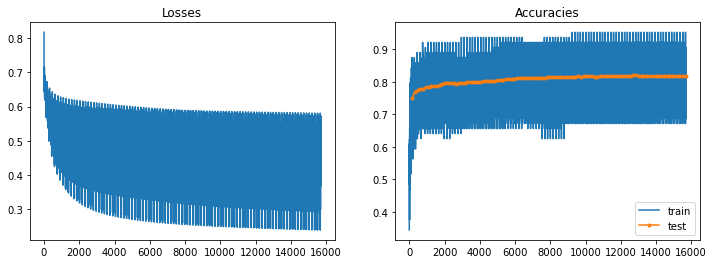

In [5]:
# You may freely modify any given template code as you see fit.

batch_size = 64
max_epoch = 100
lr = 0.001    # learning rate
lam = 0.0001   # lambda for regularization

W = np.random.normal(scale=0.01, size=(3072,))     # weight
b = 0.0     # bias

losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(max_epoch):
    steps_per_epoch = np.ceil(len(train_data) / batch_size).astype(int)
    progress_bar = tqdm.tqdm(range(steps_per_epoch))
    for step_index in progress_bar:
        # fetch next batch of training data
        x = train_data[step_index * batch_size:(step_index + 1) * batch_size]           # train_data as x (shape: [batch_size, 3072])
        y_true = train_labels[step_index * batch_size:(step_index + 1) * batch_size]    # train_labels as y (shape: [batch_size,])
        y_true = (y_true != active_label_indices[0]).astype(int)                        # make binary

        # prediction
        z_values = np.dot(x, W) + b
        y_pred = 1 / (1 + np.exp(-z_values))   # h(x) in the slides

        # calculate loss & accuracy
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) + lam * np.sum(W ** 2) / 2
        accuracy = np.mean((y_pred > 0.5).astype(int) == y_true)

        losses.append(loss)
        train_accuracies.append(accuracy)
        progress_bar.set_description(f'loss {loss:.3f} acc {accuracy:.3f}')

        # update weights
        grad_W = np.dot(x.T, y_pred - y_true) / batch_size + lam * W
        grad_b = np.mean(y_pred - y_true, axis=0)
        W -= lr * grad_W
        b -= lr * grad_b     # keep in mind that we don't apply regularization to bias

    # test accuracies
    x = test_data
    y_true = test_labels
    y_true = (y_true != active_label_indices[0]).astype(int)    # make binary

    # test prediction
    z_values = np.dot(x, W) + b
    y_pred = 1 / (1 + np.exp(-z_values))    # h(x) in the slides

    # calculate accuracy
    accuracy = np.mean((y_pred > 0.5).astype(int) == y_true)
    test_accuracies.append(accuracy)
    print(f'  - test acc: {accuracy:.3f}')

# plot loss & accuracy curve
fig, (a0, a1) = plt.subplots(1, 2, figsize=(12, 4))
_ = a0.set_title('Losses')
_ = a0.plot(losses)
_ = a1.set_title('Accuracies')
_ = a1.plot(train_accuracies, label='train')
_ = a1.plot((np.arange(max_epoch) + 1) * steps_per_epoch, test_accuracies, marker='.', label='test')
_ = a1.legend()


## 3. Report

Executive Summary:

This report presents an analysis of the performance of an image classification algorithm that uses logistic regression. The algorithm was evaluated on a dataset, and its performance was assessed in terms of loss, accuracy, and test accuracy. The results show that the algorithm performed well in classifying images, with an increase in accuracy and test accuracy and a decrease in loss during training.

Introduction:

Image classification is a challenging problem in machine learning, as it requires the algorithm to learn features that can distinguish between different objects or classes in an image. One common approach to solving this problem is to use logistic regression, which is a binary classification algorithm that is suitable for this task. In this report, we evaluate the performance of an image classification algorithm that uses logistic regression and analyze its performance using various metrics.

Performance Analysis:

The algorithm started with a loss of 0.673 and ended with a loss of 0.572, indicating that it has improved during training. The test accuracy of the algorithm increased from 0.749 to 0.819, demonstrating that the algorithm is able to accurately classify images in the test dataset. Similarly, the accuracy of the algorithm improved from 0.625 to 0.688 during training, indicating that the algorithm is getting better at classifying images over time.

Conclusion:

Overall, the results of our analysis show that the image classification algorithm that uses logistic regression performed well on the dataset. The algorithm was able to accurately classify images, as indicated by the increase in accuracy and test accuracy and the decrease in loss during training. The logistic regression algorithm used in this report is suitable for binary classification tasks and can be further optimized to improve its performance on image classification tasks. These findings have important implications for the development of image classification algorithms and may contribute to the advancement of this field in the future.